In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

11353
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

In [3]:
# -----------------------------------------------------
# --- Canonical coordinate and some constants ---
# -----------------------------------------------------
xmax_, Nx_ = np.pi, 1001

x_ = np.linspace(-xmax_, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- Planck constant: h / 2pi, h = 6.6261e−34 J*s ---
hp_ = 1.0 

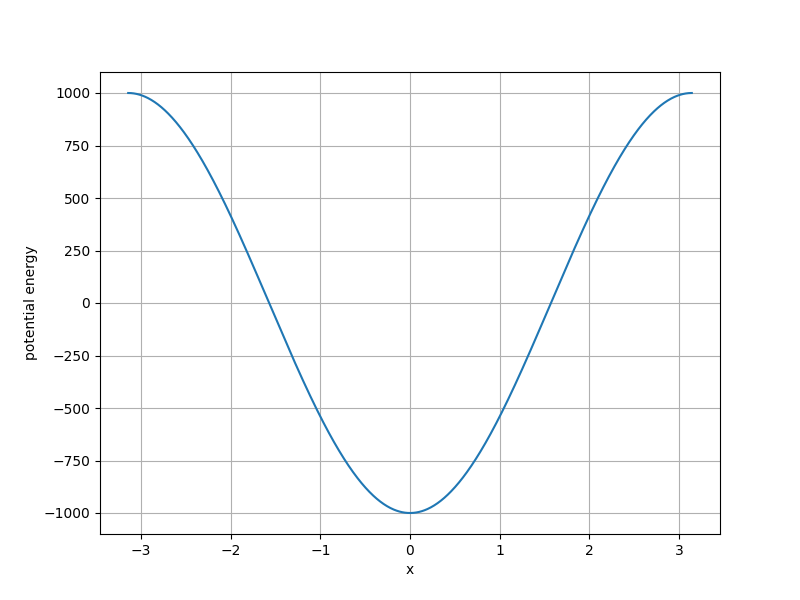

In [4]:
# -----------------------------------------------------
# --- Harmonic oscillator ---
# -----------------------------------------------------
def harm_oscillator(x, dx, Nx, EC, EJ):
    H = np.zeros((Nx, Nx))
    V = np.zeros(Nx) 

    coef0 = 4. * EC * hp_**2 / (dx**2)

    V_func = lambda x: - EJ * np.cos(x)

    for ir in range(Nx):
        # --- Potential ---
        V[ir] = V_func(x[ir])

        # --- Hamiltonian ---
        if ir == 0:
            H[ir, Nx-1] = -coef0
        else:
            H[ir, ir-1] = -coef0

        if ir == (Nx-1):
            H[ir, 0] = -coef0
        else:
            H[ir, ir+1] = -coef0
        H[ir, ir] = 2. * coef0 + V[ir]

    return H, V, V_func, "harm-osc"
# ---------------------------------------------------------------
EC_ = 1. 
EJ_ = 1000.
H_, V_, V_func_, str_H_ = harm_oscillator(x_, dx_, Nx_, EC_, EJ_)


# --- Plot potential ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_, V_)
ax.set_xlabel("x")
ax.set_ylabel("potential energy")
ax.grid()
del ax, fig

In [5]:
# ------------------------------------------------------------
# --- Compute eigenvalues and eigenvectors ---
# ------------------------------------------------------------
def compute_eig(H):
    eigVals, eigVecs = np.linalg.eig(H)

    eigVals_sorted = np.sort(eigVals)
    ids_sort = np.argsort(eigVals)

    eigVecs_sorted = eigVecs[:,ids_sort]

    return eigVals_sorted, eigVecs_sorted
# ------------------------------------------------------------
def compute_anharmonicity(eigVals):
    Nx = len(eigVals)
    dw = np.zeros(Nx-1)
    for ix in range(Nx-1):
        dw[ix] = eigVals[ix+1] - eigVals[ix]

    anh = np.zeros(Nx-2)
    for ix in range(Nx-2):
        anh[ix] = dw[ix+1] - dw[ix]    
    return dw, anh
# ------------------------------------------------------------
eigVals_sorted_, eigVecs_sorted_ = compute_eig(H_)
dw_, anh_ = compute_anharmonicity(eigVals_sorted_)
print("Done")

Done


In [6]:
# ------------------------------------------------------------
# --- Print eigenvalues and anharmonicity ---
# ------------------------------------------------------------
def print_eigvals_via_diag_matrix(M, eigVecs_sorted, N_first_eigvals, ff_print):

    # --- matrix diagonalization ---
    Pinv = np.linalg.inv(eigVecs_sorted)
    M_diagonalized = np.dot(np.dot(Pinv, M), eigVecs_sorted)

    # --- extract elements on the main diagonal (eigenvalues) ---
    H_diag_diag = np.diag(M_diagonalized)

    # --- print several first diagonal elements ---
    mix.print_array(H_diag_diag[:N_first_eigvals], ff=ff_print, n_in_row = N_first_eigvals)
    return
# -------------------------------------------------------------------
Ne_print = 20
ff_print = [6, 3, "f"]

print("--- {:d} first eigenvalues ---".format(Ne_print))
mix.print_array(eigVals_sorted_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- {:d} first eigenvalues (via diagonalization) ---".format(Ne_print))
print_eigvals_via_diag_matrix(H_, eigVecs_sorted_, Ne_print, ff_print)

print("\n--- energy differences of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(dw_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- anharmonicity of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(anh_[:Ne_print], ff=[12, 3, "e"], n_in_row = Ne_print)

del Ne_print, ff_print

--- 20 first eigenvalues ---
-955.531 -867.105 -779.709 -693.364 -608.087 -523.901 -440.828 -358.893 -278.121 -198.540 -120.182 -43.079 32.732 107.210 180.312 251.987 322.179 390.826 457.852 523.174 

--- 20 first eigenvalues (via diagonalization) ---
-955.531 -867.105 -779.709 -693.364 -608.087 -523.901 -440.828 -358.893 -278.121 -198.540 -120.182 -43.079 32.732 107.210 180.312 251.987 322.179 390.826 457.852 523.174 

--- energy differences of first 20 eigenvalues ---
88.426 87.395 86.346 85.276 84.186 83.073 81.936 80.772 79.581 78.358 77.103 75.811 74.478 73.102 71.675 70.192 68.646 67.027 65.322 63.517 

--- anharmonicity of first 20 eigenvalues ---
  -1.031e+00   -1.050e+00   -1.069e+00   -1.090e+00   -1.113e+00   -1.137e+00   -1.163e+00   -1.192e+00   -1.222e+00   -1.256e+00   -1.292e+00   -1.332e+00   -1.377e+00   -1.427e+00   -1.483e+00   -1.546e+00   -1.619e+00   -1.705e+00   -1.805e+00   -1.927e+00 


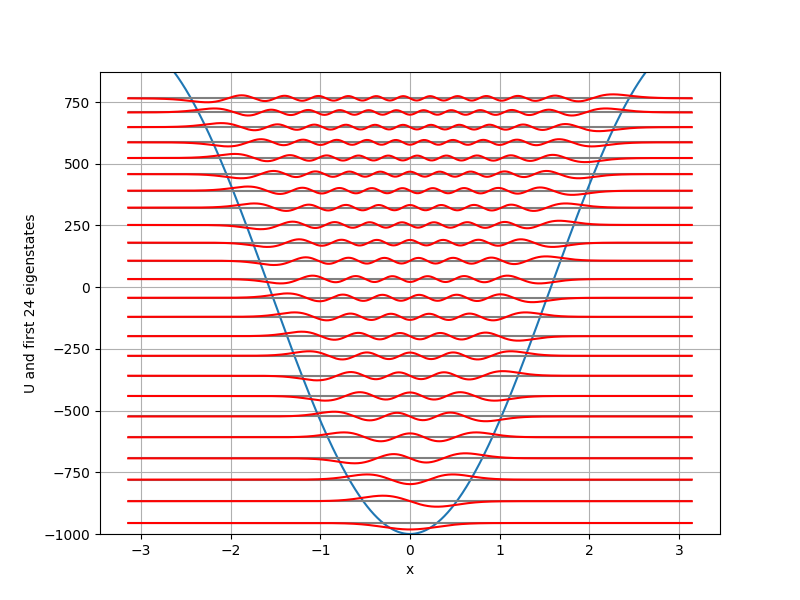

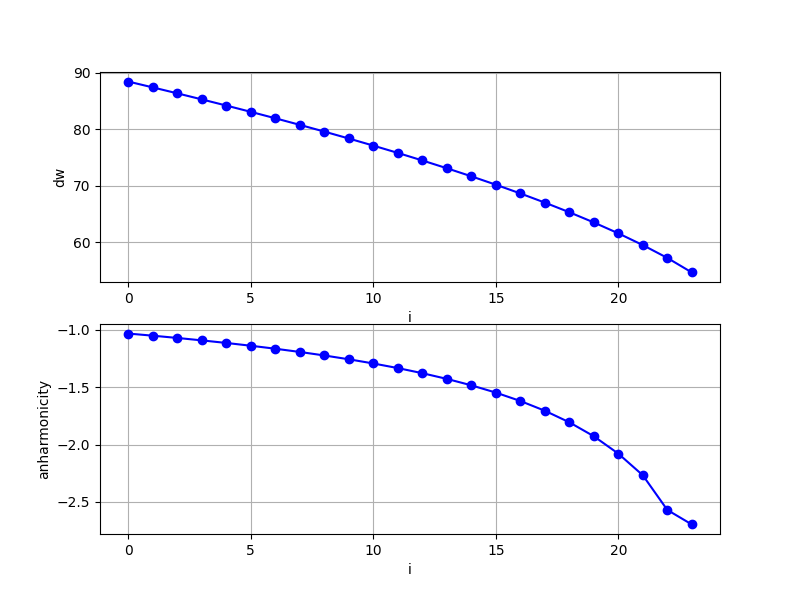

In [7]:
# ------------------------------------------------------------
# --- Plot eigenvalues, anharmonicity and eigenvectors ---
# ------------------------------------------------------------
def plot_eig_anh(N_eig, resc_eigv = 4.0, flag_eigstates = True):
    resc_eigv = resc_eigv * (N_eig/2.)  # rescaling of eigenstates

    # --- Plot eigenvalues and eigenstates ---
    if flag_eigstates:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(x_, V_, "-")
        for ii in range(N_eig):
            ax.hlines(eigVals_sorted_[ii], -xmax_, xmax_, color="gray")

            eig_vec = resc_eigv * np.array(eigVecs_sorted_[:,ii]) 
            eig_vec += eigVals_sorted_[ii] * np.ones(Nx_)
            ax.plot(x_, eig_vec, "-", color="red")
        ax.set_xlabel("x")
        ax.set_ylabel("U and first {:d} eigenstates".format(N_eig))
        # ax.set_xlim([-coef_x_lim * x_curr, coef_x_lim * x_curr])
        ax.set_ylim([-EJ_, eigVals_sorted_[N_eig+1]])
        ax.grid()

    # --- Plot energy-differences and anharomnicities ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(range(N_eig), dw_[:N_eig], "-bo")
    ax.set_xlabel("i")
    ax.set_ylabel("dw")
    ax.grid()

    ax = fig.add_subplot(212)
    ax.plot(range(N_eig), anh_[:N_eig], "-bo")
    ax.set_xlabel("i")
    ax.set_ylabel("anharmonicity")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    ax.grid()

    del N_eig
    return
# ----------------------------------------------------
plot_eig_anh(N_eig = 24, resc_eigv = 20.0, flag_eigstates = True)

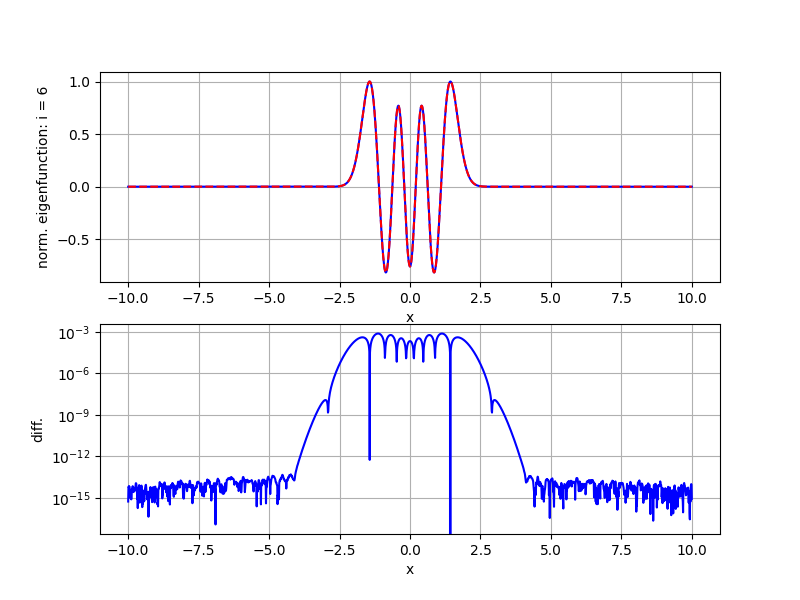

In [8]:
# ------------------------------------------------------------------
# --- Compare numerically computed and analytical eigenfunctions ---
# ------------------------------------------------------------------
import math
from scipy import special
def compare_eigfunction_with_analytics(id_to_plot):
    # --- analytical function ---
    coef_c = pow(Ca_ * w_/(np.pi * hp_), 0.25)
    coef_pol = np.sqrt(Ca_ * w_ / hp_)
    exp_func = np.exp(- Ca_ * w_ * x_**2/(2. * hp_))

    coef1 = 1./ np.sqrt(2.**id_to_plot * math.factorial(id_to_plot))
    He_pol = special.hermite(id_to_plot, monic=False)(coef_pol * x_)
    eigf_a = coef_c * coef1 * exp_func * He_pol

    eigf_a = eigf_a / np.max(np.abs(eigf_a))

    # --- num. function ---
    eigf_num = np.array(eigVecs_sorted_[:,id_to_plot])
    eigf_num /= np.max(np.abs(eigf_num))

    # --- correct the sign ---
    sign_func = 1.0
    if(np.sum(eigf_num * eigf_a) < 0):
        sign_func = -1

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(x_, eigf_num, "-b")
    ax.plot(x_, sign_func * eigf_a,   "--r")
    ax.set_xlabel("x")
    ax.set_ylabel("norm. eigenfunction: i = {:d}".format(id_to_plot))
    ax.grid()

    ax = fig.add_subplot(212)
    ax.plot(x_, np.abs(eigf_num - sign_func * eigf_a), "-b")
    ax.set_yscale('log')
    ax.set_xlabel("x")
    ax.set_ylabel("diff.")
    ax.grid()
    return
# --------------------------------------------------------------------------
compare_eigfunction_with_analytics(id_to_plot = 6)